## A/B test result analysis

The experiment on users was carried out for 2 weeks. As a result, we received raw data about the experiment, which we need to process and draw conclusions about whether the recommendations improved when using the test model.

**Data description:**

* *Our service responses with recommendations* &ndash; in them we know which user we recommended what and to which group they were assigned. And, of course, we know the moment in time when it happened.

* *Likes data* &ndash; in them we know which user and which post liked, including the moment in time when this happened.

### Data loading

In [48]:
import hashlib
from os.path import join
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy.stats import binomtest, mannwhitneyu, ttest_ind

In [3]:
data_folder = "data"

In [6]:
views = pd.read_csv(join(data_folder, "views.csv"))
likes = pd.read_csv(join(data_folder, "likes.csv"))

In [7]:
views.head()

,user_id,exp_group,recommendations,timestamp
0,128381,control,[3644 4529 4704 5294 4808],1654030803
1,146885,test,[1399 1076 797 7015 5942],1654030811
2,50948,test,[2315 3037 1861 6567 4093],1654030825
3,37703,test,[2842 1949 162 1588 6794],1654030826
4,14661,test,[2395 5881 5648 3417 673],1654030829


In [8]:
likes.head()

,user_id,post_id,timestamp
0,128381,4704,1654030804
1,146885,1399,1654030816
2,50948,2315,1654030828
3,14661,673,1654030831
4,37703,1588,1654030833


### Group split check

Let's start by checking the splitting of groups.

First, we don't have a user-group mapping because we actually defined the user's group right before making recommendations.

It may seem that this guarantees us a one-to-one correspondence of groups for users, but let's check it. In reality, there are system lags (for example, if we request a user group, we can not always get a response) and this property is not fulfilled. Let's check if we have users who are in both groups.  If there are few of them, then we will simply delete such users, and if there were a lot of them, we would have to figure out what went wrong.

In [9]:
tmp = views.groupby("user_id").exp_group.nunique().reset_index()
tmp[tmp.exp_group > 1]

,user_id,exp_group
10071,25623,2
20633,55788,2
54475,142283,2
57065,148670,2


Only 4 users, delete them.

In [10]:
bad_users = tmp[tmp.exp_group > 1].user_id.values

views = views[~np.in1d(views.user_id, bad_users)]
likes = likes[~np.in1d(likes.user_id, bad_users)]

Check that the groups are split evenly.

In [14]:
views.groupby("user_id").first().exp_group.value_counts(normalize="True")

test       0.502377
control    0.497623
Name: exp_group, dtype: float64

The users seem to be distributed evenly across groups. To be sure, check this using the *binomial test*.

In [18]:
control_proportion = 0.5
test_group_count = views.groupby('user_id').first().exp_group.value_counts()["test"]
control_group_count = views.groupby('user_id').first().exp_group.value_counts()["control"]

print(f"The number of users in control group: {control_group_count}, in test group: {test_group_count}.")

The number of users in control group: 32350, in test group: 32659.


In [19]:
binomtest(k=control_group_count, 
          n=(control_group_count + test_group_count),
          p=control_proportion)

BinomTestResult(k=32350, n=65009, alternative='two-sided', proportion_estimate=0.49762340598993987, pvalue=0.2270501563614752)

It seems that everything is fine, and the proportion of users in the control group is not significantly different from 0.5

### Proportion of users who made at least one like

Let's collect the split into groups.

In [20]:
groups = views.groupby("user_id").first().reset_index()[["user_id", "exp_group"]]
groups.head()

,user_id,exp_group
0,200,test
1,201,test
2,202,test
3,212,test
4,213,test


Let's count the number of likes per user.

In [21]:
users_w_likes = (
    likes
    .groupby("user_id")
    .post_id.count()
    .reset_index()
    .rename(columns={"post_id": "like_num"})
)
users_w_likes.head()

,user_id,like_num
0,200,1
1,201,3
2,202,2
3,212,4
4,213,7


Merge everything.

In [22]:
tmp = pd.merge(groups, users_w_likes, on="user_id", how="left")
tmp.like_num = tmp.like_num.fillna(0)
tmp["has_like"] = (tmp["like_num"] > 0).astype(int)
tmp.groupby("exp_group")[["has_like", "like_num"]].mean()

,has_like,like_num
exp_group,,
control,0.891314,3.487079
test,0.898160,3.592578


Now let's evaluate whether the number of likes differ between groups. The number of clicks per user is log-normally distributed when visualized. So it is better to apply non-parametric criteria, such as the Mann-Whitney-Wilcoxon test.

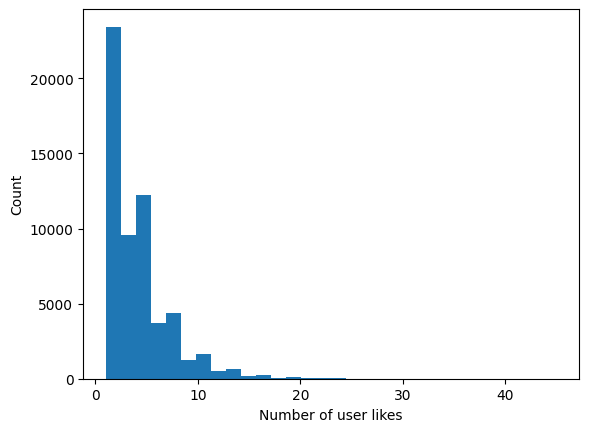

In [35]:
plt.hist(users_w_likes["like_num"], bins=30)
plt.xlabel("Number of user likes")
plt.ylabel("Count");

In [36]:
mannwhitneyu(
    tmp[tmp.exp_group == "control"].like_num,
    tmp[tmp.exp_group == "test"].like_num,
)

MannwhitneyuResult(statistic=518358073.0, pvalue=2.9585062792441964e-05)

We see that the changes are significant in this case as well.

### *Hitrate* metric

And now let's do the most difficult thing - calculate the *hitrate* (or the proportion of recommendations that users clicked on). To do this, we want to collect information about the recommended posts and the corresponding clicks in one table.

Connect all pairs of recommendations and user clicks (don't forget about recommendations without clicks).

In [37]:
tmp = pd.merge(views, likes, on="user_id", how="outer")
tmp.post_id = tmp.post_id.fillna(-1).astype(int)

Parse the recommendations.

In [38]:
tmp["recommendations"] = tmp.recommendations.apply(
    lambda x: list(map(int, filter(bool, x[1:-1].split(" "))))
)

Let's run through all the recommendations and compare with the likes. Let's mark something too old or from the future, likes for unseen recommendations.

In [39]:
tmp.post_id = tmp.apply(
    lambda row:
    -1
    if
        (row.post_id == -1) | 
        ((row.timestamp_x > row.timestamp_y) &
         (row.timestamp_x + 60 * 60 < row.timestamp_y)) |
        (row.post_id not in row.recommendations)
    else
    row.post_id, axis=1)

Let's unify:

In [40]:
def my_agg(values):
    values = set(values)
    if -1 in values and len(values) >= 2:
        return 1
    elif -1 not in values:
        return 1
    return 0

tmp_agg = tmp.groupby(["user_id", "exp_group", "timestamp_x"]).post_id.agg(my_agg)

And now let's calculate the *hitrate* metric.

In [41]:
tmp_agg.reset_index().post_id.mean()

0.7143758925429973

Now let's evaluate the difference between groups and significance. We cannot use the z-test for proportions here, since we can have the same user several times in each group. Let's apply the bucket approach (that is, let's move on to buckets and evaluate the significance from them) to post group *hitrate* (or CTR). Let's use 100 buckets. The significance level will remain the same at 0.05.

In [44]:
tmp_agg = tmp_agg.reset_index().rename(columns={"post_id": "hitrate"})

Let's prepare the buckets:

In [45]:
tmp_agg["bucket"] = tmp_agg["user_id"].apply(
    lambda x: int(hashlib.md5((str(x) + "qwerty").encode()).hexdigest(), 16) % 100
)

In [46]:
tmp_agg["view"] = 1

new_df = tmp_agg.groupby(["exp_group", "bucket"]).sum(["hitrate", "view"]).reset_index()
new_df["hitrate_new"] = new_df.hitrate / new_df.view

new_df.head()

,exp_group,bucket,user_id,timestamp_x,hitrate,view,hitrate_new
0,control,0,68497678,1452753654500,620,878,0.706150
1,control,1,92587302,1770459715903,741,1070,0.692523
2,control,2,71983477,1409748804912,622,852,0.730047
3,control,3,79301948,1609945571944,705,973,0.724563
4,control,4,78686811,1510680763550,645,913,0.706462


Calculate metric:

In [47]:
tmp_agg.groupby('exp_group').hitrate.mean()

exp_group
control    0.707741
test       0.720975
Name: hitrate, dtype: float64

The difference is quite big. But what about significance?

In [49]:
mannwhitneyu(
    new_df[new_df.exp_group == "control"].hitrate_new,
    new_df[new_df.exp_group == "test"].hitrate_new,
)

MannwhitneyuResult(statistic=2761.5, pvalue=4.543507652438907e-08)

In [50]:
ttest_ind(
    new_df[new_df.exp_group == "control"].hitrate_new,
    new_df[new_df.exp_group == "test"].hitrate_new,
)

Ttest_indResult(statistic=-5.448160740759767, pvalue=1.5005541448404563e-07)

Significant change. Metric improved in both tests.

### Results

* A/B test was done;
* Analysis of its results showed that the metric improved significantly.